In [1]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
import shutil
import random

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
image_folder = '/content/drive/MyDrive/Med/data/training_set/images'
df = pd.read_csv(r'/content/drive/MyDrive/Med/data/train.csv')

In [4]:
df.columns

Index(['filename', 'pixel size(mm)', 'head circumference (mm)'], dtype='object')

In [5]:
IMG_SIZE = 224
MAX_HC = df['head circumference (mm)'].max()

def load_and_resize_image(filename, img_folder):
    img_path = os.path.join(img_folder, filename)
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    return img

def augment_image(image):
    augmented_images = []
    augmented_images.append(image)
    flipped = cv2.flip(image, 1)
    augmented_images.append(flipped)
    angle = random.uniform(-10, 10)
    h, w = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1)
    rotated = cv2.warpAffine(image, rotation_matrix, (w, h), borderMode=cv2.BORDER_REFLECT)
    augmented_images.append(rotated)

    return augmented_images

# Split into train (600) and temp (400)
train_df, temp_df = train_test_split(
    df,
    train_size=600,
    random_state=42,
    shuffle=True
)

# Split temp into val (200) and test (200)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    shuffle=True
)

print(f"Train set (before augmentation): {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")
print(f"Test set: {len(test_df)} images")

# --- Step 2: Augment the Train Set ---

augmented_images = []
augmented_hc_values = []

for idx, row in train_df.iterrows():
    filename = row['filename']
    hc_mm = row['head circumference (mm)']

    # Load and resize the image
    img = load_and_resize_image(filename, image_folder)

    # Apply augmentations (original + flipped + rotated)
    augmented_versions = augment_image(img)

    # Append each augmented version
    for aug_img in augmented_versions:
        augmented_images.append(aug_img)
        augmented_hc_values.append(hc_mm)

# Convert to NumPy arrays
X_train = np.array(augmented_images, dtype=np.float32)
y_train = np.array(augmented_hc_values, dtype=np.float32) / MAX_HC

# --- Step 3: Prepare Validation Set (No Augmentation) ---

val_images = []
val_hc_values = []

for idx, row in val_df.iterrows():
    filename = row['filename']
    hc_mm = row['head circumference (mm)']

    img = load_and_resize_image(filename, image_folder)

    val_images.append(img)
    val_hc_values.append(hc_mm)

X_val = np.array(val_images, dtype=np.float32)
y_val = np.array(val_hc_values, dtype=np.float32) / MAX_HC

# --- Step 4: Prepare Test Set (No Augmentation) ---

test_images = []
test_hc_values = []

for idx, row in test_df.iterrows():
    filename = row['filename']
    hc_mm = row['head circumference (mm)']

    img = load_and_resize_image(filename, image_folder)

    test_images.append(img)
    test_hc_values.append(hc_mm)

X_test = np.array(test_images, dtype=np.float32)
y_test = np.array(test_hc_values, dtype=np.float32) / MAX_HC

# --- Final Shape Info ---
print(f"Train samples after augmentation: {len(X_train)} (Expected: 600 × 3 = 1800)")
print(f"Validation samples: {len(X_val)} (Expected: 200)")
print(f"Test samples: {len(X_test)} (Expected: 200)")

Train set (before augmentation): 600 images
Validation set: 199 images
Test set: 200 images
Train samples after augmentation: 1800 (Expected: 600 × 3 = 1800)
Validation samples: 199 (Expected: 200)
Test samples: 200 (Expected: 200)


In [6]:
# Input shape (224x224x3)
input_shape = (224, 224, 3)

# Load EfficientNetB2 backbone without top classifier, pretrained on ImageNet
base_model = EfficientNetB2(include_top=False, weights='imagenet', input_shape=input_shape)

# Set ALL layers as trainable (full fine-tuning)
base_model.trainable = True

# Build the regression model
inputs = tf.keras.Input(shape=input_shape)
x = base_model(inputs, training=True)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.7)(x)  # High dropout to prevent overfitting
outputs = layers.Dense(1, activation='linear')(x)

model = models.Model(inputs=inputs, outputs=outputs)

# Compile the model (Adam optimizer, MAE loss)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mae',
    metrics=['mae']
)

# Model summary (optional)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb2 (Functional)          │ (None, 7, 7, 1408)          │       7,768,569 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1408)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,409 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,769,978 (29.64 MB)

 Trainable params: 7,702,403 (29.38 MB)

 Non-trainable params: 67,575 (263.97 KB)

In [7]:
print(f"Number of layers in the base model: {len(base_model.layers)}")


Number of layers in the base model: 340


In [8]:
# 1. Callbacks

checkpoint = ModelCheckpoint(
    'best_model.h5',             # Save the best model here
    monitor='val_loss',          # Watch validation loss (MAE)
    save_best_only=True,         # Save only the best weights
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',          # Stop if val_loss stops improving
    patience=10,                 # Wait 10 epochs before stopping
    restore_best_weights=True,   # Roll back to best weights after stopping
    verbose=1
)

callbacks = [checkpoint, early_stop]

# 2. Training Parameters

epochs = 100
batch_size = 16

# 3. Train the Model

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks
)


Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - loss: 0.4813 - mae: 0.4813
Epoch 1: val_loss improved from inf to 0.54804, saving model to best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 203s 813ms/step - loss: 0.4809 - mae: 0.4809 - val_loss: 0.5480 - val_mae: 0.5480
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.3386 - mae: 0.3386
Epoch 2: val_loss improved from 0.54804 to 0.29897, saving model to best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 70s 120ms/step - loss: 0.3385 - mae: 0.3385 - val_loss: 0.2990 - val_mae: 0.2990
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.2798 - mae: 0.2798
Epoch 3: val_loss did not improve from 0.29897
113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.2796 - mae: 0.2796 - val_loss: 0.4345 - val_mae: 0.4345
Epoch 4/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.2339 - mae: 0.2339
Epoch 4: val_loss improved from 0.29897 to 0.20784, saving model to best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 13s 119ms/step - loss: 0.2339 - mae: 0.2339 - val_loss: 0.2078 - val_mae: 0.2078
Epoch 5/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.2029 - mae: 0.2029
Epoch 5: val_loss did not improve from 0.20784
113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - loss: 0.2028 - mae: 0.2028 - val_loss: 0.2419 - val_mae: 0.2419
Epoch 6/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.1659 - mae: 0.1659
Epoch 6: val_loss improved from 0.20784 to 0.13568, saving model to best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 22s 125ms/step - loss: 0.1658 - mae: 0.1658 - val_loss: 0.1357 - val_mae: 0.1357
Epoch 7/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.1517 - mae: 0.1517
Epoch 7: val_loss did not improve from 0.13568
113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - loss: 0.1517 - mae: 0.1517 - val_loss: 0.3573 - val_mae: 0.3573
Epoch 8/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.1264 - mae: 0.1264
Epoch 8: val_loss did not improve from 0.13568
113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 109ms/step - loss: 0.1264 - mae: 0.1264 - val_loss: 0.2535 - val_mae: 0.2535
Epoch 9/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.1125 - mae: 0.1125
Epoch 9: val_loss did not improve from 0.13568
113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - loss: 0.1125 - mae: 0.1125 - val_loss: 0.3287 - val_mae: 0.3287
Epoch 10/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.1101 - mae: 0.1101
Epoch 10: val_loss did not improve from 0.13568
113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 1

113/113 ━━━━━━━━━━━━━━━━━━━━ 22s 123ms/step - loss: 0.0773 - mae: 0.0773 - val_loss: 0.1188 - val_mae: 0.1188
Epoch 16/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.0749 - mae: 0.0749
Epoch 16: val_loss did not improve from 0.11876
113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step - loss: 0.0749 - mae: 0.0749 - val_loss: 0.2370 - val_mae: 0.2370
Epoch 17/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.0700 - mae: 0.0700
Epoch 17: val_loss did not improve from 0.11876
113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 111ms/step - loss: 0.0699 - mae: 0.0699 - val_loss: 0.1326 - val_mae: 0.1326
Epoch 18/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.0709 - mae: 0.0709
Epoch 18: val_loss did not improve from 0.11876
113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - loss: 0.0708 - mae: 0.0708 - val_loss: 0.2228 - val_mae: 0.2228
Epoch 19/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.0681 - mae: 0.0681
Epoch 19: val_loss did not improve from 0.11876
113/113 ━━━━━━━━━━━━━━━━━━━━

113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - loss: 0.0609 - mae: 0.0609 - val_loss: 0.0947 - val_mae: 0.0947
Epoch 22/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.0583 - mae: 0.0583
Epoch 22: val_loss did not improve from 0.09475
113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - loss: 0.0583 - mae: 0.0583 - val_loss: 0.2331 - val_mae: 0.2331
Epoch 23/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.0553 - mae: 0.0553
Epoch 23: val_loss improved from 0.09475 to 0.06328, saving model to best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 22s 125ms/step - loss: 0.0553 - mae: 0.0553 - val_loss: 0.0633 - val_mae: 0.0633
Epoch 24/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.0548 - mae: 0.0548
Epoch 24: val_loss did not improve from 0.06328
113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - loss: 0.0548 - mae: 0.0548 - val_loss: 0.0653 - val_mae: 0.0653
Epoch 25/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.0540 - mae: 0.0540
Epoch 25: val_loss did not improve from 0.06328
113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 0.0540 - mae: 0.0540 - val_loss: 0.1778 - val_mae: 0.1778
Epoch 26/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.0529 - mae: 0.0529
Epoch 26: val_loss did not improve from 0.06328
113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - loss: 0.0529 - mae: 0.0529 - val_loss: 0.2193 - val_mae: 0.2193
Epoch 27/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.0471 - mae: 0.0471
Epoch 27: val_loss did not improve from 0.06328
113/113 ━━━━━━━━━━━━━━━━━━━━

113/113 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - loss: 0.0496 - mae: 0.0496 - val_loss: 0.0584 - val_mae: 0.0584
Epoch 30/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.0480 - mae: 0.0480
Epoch 30: val_loss did not improve from 0.05837
113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 112ms/step - loss: 0.0480 - mae: 0.0480 - val_loss: 0.1108 - val_mae: 0.1108
Epoch 31/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.0455 - mae: 0.0455
Epoch 31: val_loss improved from 0.05837 to 0.04336, saving model to best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - loss: 0.0455 - mae: 0.0455 - val_loss: 0.0434 - val_mae: 0.0434
Epoch 32/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.0461 - mae: 0.0461
Epoch 32: val_loss did not improve from 0.04336
113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.0461 - mae: 0.0461 - val_loss: 0.0574 - val_mae: 0.0574
Epoch 33/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.0425 - mae: 0.0425
Epoch 33: val_loss did not improve from 0.04336
113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 109ms/step - loss: 0.0425 - mae: 0.0425 - val_loss: 0.1202 - val_mae: 0.1202
Epoch 34/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.0420 - mae: 0.0420
Epoch 34: val_loss did not improve from 0.04336
113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - loss: 0.0420 - mae: 0.0420 - val_loss: 0.0901 - val_mae: 0.0901
Epoch 35/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.0411 - mae: 0.0411
Epoch 35: val_loss did not improve from 0.04336
113/113 ━━━━━━━━━━━━━━━━━━━━

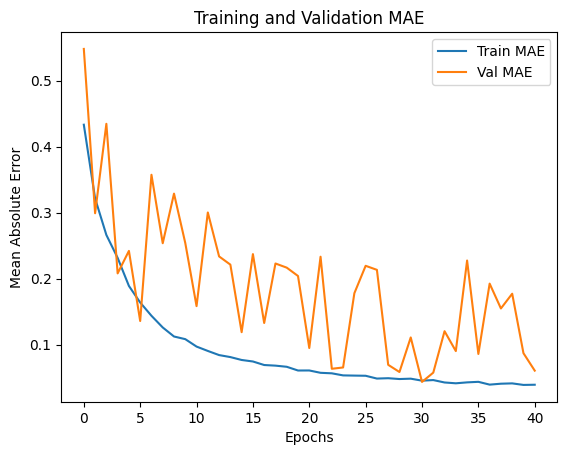

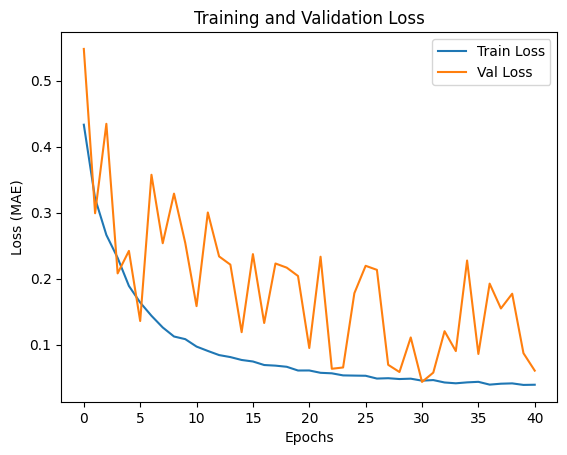

In [12]:
import matplotlib.pyplot as plt

# Plot MAE
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.title('Training and Validation MAE')
plt.legend()
plt.show()

# Plot Loss (MAE in this case)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MAE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [13]:
import numpy as np

# 1. Load the best saved model (optional if you have early_stopping with restore_best_weights=True)
model.load_weights('best_model.h5')

# 2. Predict on the test set
y_pred_norm = model.predict(X_test)

# 3. Denormalize predictions and ground truth (back to mm)
y_pred_mm = y_pred_norm.flatten() * MAX_HC
y_test_mm = y_test.flatten() * MAX_HC

# 4. Calculate Mean Absolute Error (in mm)
test_mae_mm = np.mean(np.abs(y_pred_mm - y_test_mm))
print(f"Test MAE (in mm): {test_mae_mm:.2f}")

# 5. Optional: Percentage Mean Absolute Error (PMAE)
pmae = np.mean(np.abs(y_pred_mm - y_test_mm) / y_test_mm) * 100
print(f"Percentage MAE (PMAE): {pmae:.2f}%")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Test MAE (in mm): 17.42
Percentage MAE (PMAE): 11.90%


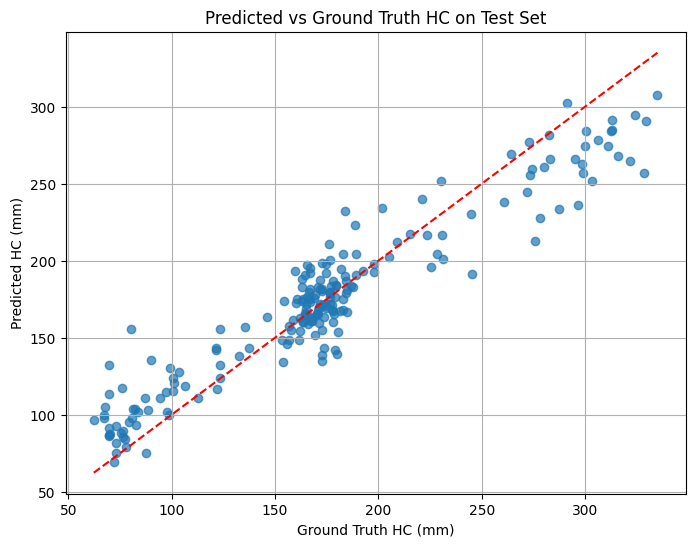

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test_mm, y_pred_mm, alpha=0.7)
plt.plot([y_test_mm.min(), y_test_mm.max()], [y_test_mm.min(), y_test_mm.max()], 'r--')
plt.xlabel('Ground Truth HC (mm)')
plt.ylabel('Predicted HC (mm)')
plt.title('Predicted vs Ground Truth HC on Test Set')
plt.grid(True)
plt.show()
